# <span style="color:rgb(0,162,162)"><strong>Sommaire</strong></span> <a class="anchor" id="0"></a>

* ## 0. [Define functions](#10)
* ## 1. [Introduction](#1)    
    * ### 1.1 [Project description](#1.1)    
    * ### 1.2 [Importing libraries](#1.2)
* ## 2. [Exploratory Data Analysis](#2)
    * ### 2.1 [Number of pages](#2.1)
    * ### 2.2 [Ratings count](#2.2)
    * ### 2.3 [Text reviews count](#2.3)
    * ### 2.4 [Rating by reviews](#2.4)
    * ### 2.5 [Reviews by ratings](#2.5)
    * ### 2.6 [Publishers](#2.6)
    * ### 2.7 [Publication date](#2.7)
    * ### 2.8 [Authors](#2.8)
    * ### 2.9 [Features scaling](#2.9)
* ## 3. [Training models](#3)
    * ### 3.1 [Linear Regression](#3.1)
    * ### 3.2 [Decision Tree](#3.2)
    * ### 3.3 [Random Forest](#3.3)
    * ### 3.4 [Gradient Boosting](#3.4)
    * ### 3.5 [Neural Network](#3.5)
* ## 4. [Models analysis](#4)

<a id="10"></a>
## [0. Define functions](#10)
[Sommaire](#0)

In [1]:
def show_models_perf(models_dict):
    for key, values in models_dict.items():
        print(key)
        for value in values:
            print()
            
def regression_metrics(y_true, y_pred, form=':.4d'):
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmsle = np.sqrt(metrics.mean_squared_log_error(y_true, y_pred))
    r2 = metrics.r2_score(y_true, y_pred)
    print(f"RMSE : {rmse:.4f}\nMSE : {mse:.4f}\nMAE : {mae:.4f}\nR2 : {r2:.4f}\nRMSLE : {rmsle:.4f}")

## [1. Introduction](#1)<a id="1"></a>
[Sommaire](#0)    

### [1.1 Project description](#1.1)<a id="1.1"></a>
The aim of this project is to train a model that predict's a book rating.

### [1.2 Importing libraries](#1.2)<a id="1.2"></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics, tree
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

<a id="2"></a>
## [2. Exploratory Data Analysis](#2)
[Sommaire](#0)

In [3]:
base_df = pd.read_csv('books.csv', sep=',', header=0, index_col=0, on_bad_lines='skip')
df = base_df.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11123 entries, 1 to 45641
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               11123 non-null  object 
 1   authors             11123 non-null  object 
 2   average_rating      11123 non-null  float64
 3   isbn                11123 non-null  object 
 4   isbn13              11123 non-null  int64  
 5   language_code       11123 non-null  object 
 6     num_pages         11123 non-null  int64  
 7   ratings_count       11123 non-null  int64  
 8   text_reviews_count  11123 non-null  int64  
 9   publication_date    11123 non-null  object 
 10  publisher           11123 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 1.0+ MB


First, we have a problem in one column name : '  num_pages', there is unnecessary spaces before the column name. Whe should correct it to 'num_pages'    
We can also see that we don't have any null values in our columns.    
Moreover, dtypes are for most correct, except for *publication_date* that we are going to change now from ***object*** to ***datetime***

In [4]:
df = df.rename(columns={'  num_pages': 'num_pages'})
df.describe()

,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


The above table shows us a lot of information 
1. Some books have an average rating og 0
2. Some book don't have pages
3. Is the first question related to the fact that some book have 0 pages, 0 ratings count and 0 text_reviews

Check if there is indeed no null values or NaN in the dataset

In [5]:
test_dic = {}
for col in df.columns.tolist():
    test_dic[col] = [df[df[col].isna()].shape[0], df[df[col].isnull()].shape[0]]

test_dic

{'title': [0, 0],
 'authors': [0, 0],
 'average_rating': [0, 0],
 'isbn': [0, 0],
 'isbn13': [0, 0],
 'language_code': [0, 0],
 'num_pages': [0, 0],
 'ratings_count': [0, 0],
 'text_reviews_count': [0, 0],
 'publication_date': [0, 0],
 'publisher': [0, 0]}

Checking why there is *average_rating* at 0    
Is there any explanation ?

In [6]:
df.loc[df['average_rating'] == 0].shape[0]

25

There is 25 rows where the rating is at 0, let's see if it's because books have never been rated

In [7]:
df.loc[(df['average_rating'] == 0) & (df['ratings_count'] != 0)]

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,


The above dataframe search for books that have an average rating of 0 and a ratings count different of 0.    
As we can see, the result is an empty dataframe, which means that no book have matched both conditions.    
As these beeks have never been rated, we can delete them from the dataframe because they are not relevant

In [8]:
df.loc[(df['average_rating'] != 0) & (df['ratings_count'] == 0)].sample(3)

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
17045,American Government: Continuity and Change Te...,Karen O'Connor/Larry J. Sabato,2.83,0321365607,9780321365606,eng,1088,0,0,5/26/2005,Longman Publishing Group
22834,らんま½ 12,Rumiko Takahashi,4.06,409126512X,9784091265128,jpn,176,0,0,9/18/2002,小学館 [Shōgakukan]
21342,Math Fables,Greg Tang/Heather Cahoon,4.03,043945400X,9780439454001,eng,40,0,0,1/1/1949,Scholastic Inc.


On the above dataframe there is something very strange :    
- These books have an average rating different to 0, but they have never been rated as the ratings_count is 0    

We take the decision to **delete** from the dataset all the books that have an average rating but that have never been rated

In [9]:
df.loc[df['ratings_count'] == 0].shape

(80, 11)

In [10]:
df = df.loc[df['ratings_count'] > 0]
df.shape

(11043, 11)

In [11]:
df['publication_date'].sample(10)

bookID
41840      8/1/1985
36140      6/4/2005
14376     11/9/2004
31672     3/28/2006
1495       9/1/1998
40913     12/1/1989
12290      5/1/1992
12684     10/1/2002
43888    11/15/1998
33692      2/3/2004
Name: publication_date, dtype: object

In [12]:
df.loc[:, 'publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors='coerce')

C:\Users\flori\AppData\Local\Temp\ipykernel_29040\3031704706.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors='coerce')


***errors='coerce'*** means that we don't keep the rows where there is an error in the publication date.

In [13]:
df = df[~df['publication_date'].isnull()]

In [14]:
df.shape

(11041, 11)

As the book has for index bookID, but this column doesn't serves, we can reset the index of the dataframe and deleting bookID    


Moreover, isbn and isbn13 stands for **International Standard Book Number**, which uniquely identifies a book, so it does not have a sens to keep this for predicting average rating

In [15]:
df = df.reset_index()
df = df.drop(columns=['bookID', 'isbn13', 'isbn'])

In [16]:
df.shape

(11041, 9)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11041 entries, 0 to 11040
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   title               11041 non-null  object        
 1   authors             11041 non-null  object        
 2   average_rating      11041 non-null  float64       
 3   language_code       11041 non-null  object        
 4   num_pages           11041 non-null  int64         
 5   ratings_count       11041 non-null  int64         
 6   text_reviews_count  11041 non-null  int64         
 7   publication_date    11041 non-null  datetime64[ns]
 8   publisher           11041 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 776.4+ KB


<a id="2.1"></a>
## [2.1 Number of pages](#2.1)
[Sommaire](#0)

In [18]:
df['num_pages'].describe()

count    11041.000000
mean       336.703741
std        240.978566
min          0.000000
25%        194.000000
50%        300.000000
75%        416.000000
max       6576.000000
Name: num_pages, dtype: float64

In [19]:
print(df.loc[df['num_pages'] == 0].shape)
df = df.loc[df['num_pages'] > 0]

(75, 9)


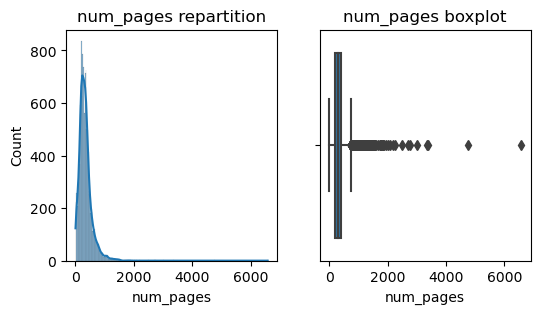

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

axs.flat[0].set_title('num_pages repartition')
sns.histplot(data=df, x='num_pages', bins=250, kde=True, ax=axs[0])
axs.flat[1].set_title('num_pages boxplot')
sns.boxplot(data=df, x='num_pages', ax=axs[1])

plt.show()

In [21]:
q1, q3 = df['num_pages'].quantile(0.25), df['num_pages'].quantile(0.75)
np_iqr = q3 - q1
np_low, np_up = q1 - (1.5 * np_iqr), q3 + (1.5 * np_iqr)
print(f"Lower outliers : {np_low}\nUpper outliers : {np_up}")

Lower outliers : -131.5
Upper outliers : 744.5


In [22]:
print(f"Num_pages total outliers : {df.loc[df['num_pages'] > np_up].shape[0]}")

Num_pages total outliers : 560


In [23]:
df = df.loc[df['num_pages'] <= np_up]

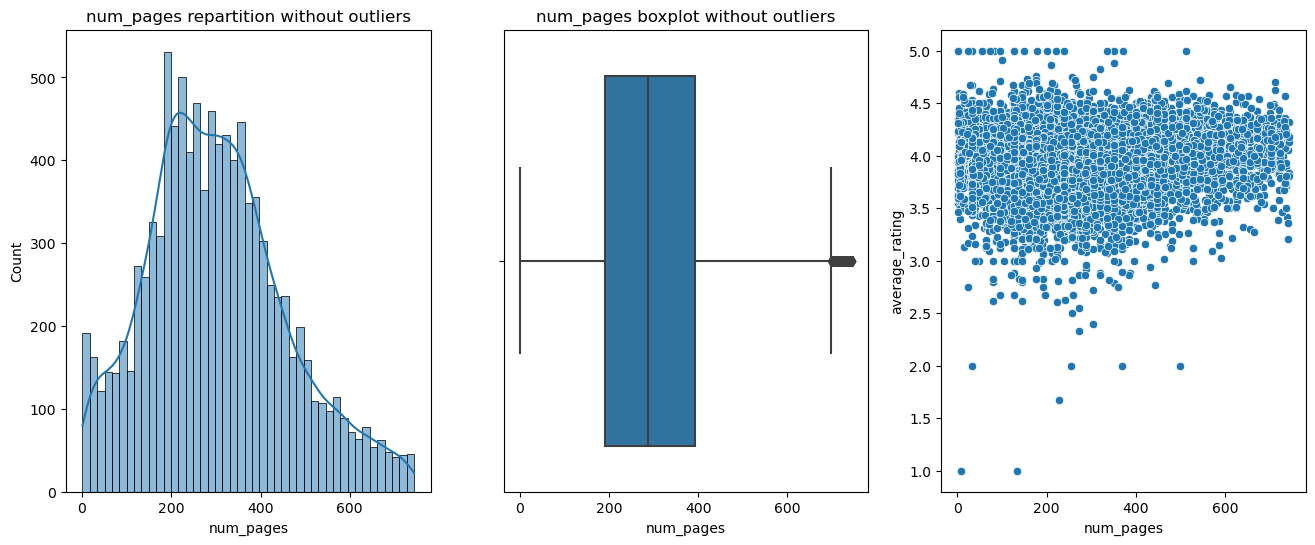

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs.flat[0].set_title('num_pages repartition without outliers')
sns.histplot(data=df, x='num_pages', bins=45, kde=True, ax=axs[0])
axs.flat[1].set_title('num_pages boxplot without outliers')
sns.boxplot(data=df, x='num_pages', ax=axs[1])
sns.scatterplot(data=df, x='num_pages', y='average_rating', ax=axs[2])

plt.show()

<a id="2.2"></a>
## [2.2 Ratings count](#2.2)
[Sommaire](#0)

In [25]:
df['ratings_count'].describe()

count    1.040600e+04
mean     1.802533e+04
std      1.131702e+05
min      1.000000e+00
25%      1.120000e+02
50%      7.785000e+02
75%      5.071500e+03
max      4.597666e+06
Name: ratings_count, dtype: float64

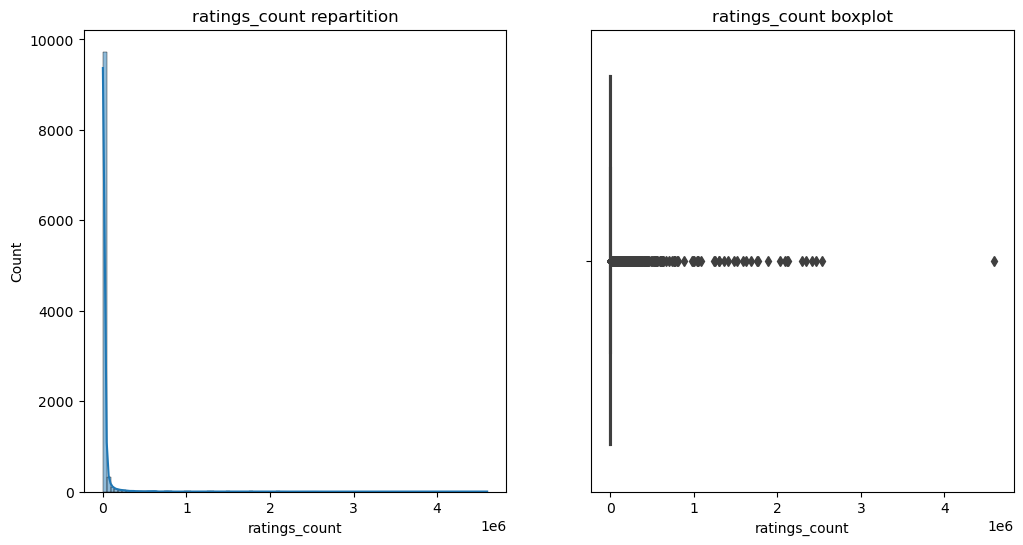

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs.flat[0].set_title('ratings_count repartition')
sns.histplot(data=df, x='ratings_count', bins=100, kde=True, ax=axs[0])
axs.flat[1].set_title('ratings_count boxplot')
sns.boxplot(data=df, x='ratings_count', ax=axs[1])

plt.show()

In [27]:
q1, q3 = df['ratings_count'].quantile(0.25), df['ratings_count'].quantile(0.75)
rc_iqr = q3 - q1
rc_low, rc_up = q1 - (1.5 * rc_iqr), q3 + (1.5 * rc_iqr)
print(f"Lower outliers : {rc_low}\nUpper outliers : {rc_up}")

Lower outliers : -7327.25
Upper outliers : 12510.75


In [28]:
print(f"Ratings_count total outliers : {df.loc[df['ratings_count'] > rc_up].shape[0]}")

Ratings_count total outliers : 1608


In [29]:
df = df.loc[df['ratings_count'] <= rc_up]
df.shape[0]

8798

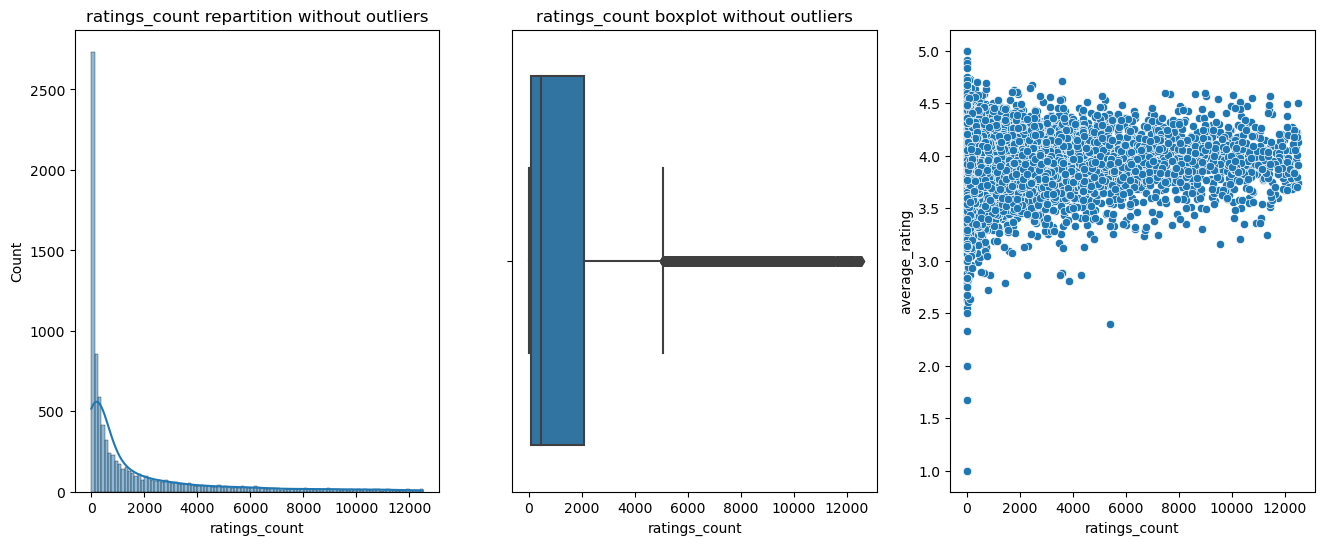

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs.flat[0].set_title('ratings_count repartition without outliers')
sns.histplot(data=df, x='ratings_count', bins=100, kde=True, ax=axs[0])
axs.flat[1].set_title('ratings_count boxplot without outliers')
sns.boxplot(data=df, x='ratings_count', ax=axs[1])
sns.scatterplot(data=df, x='ratings_count', y='average_rating', ax=axs[2])

plt.show()

<a id="2.3"></a>
## [2.3 Text reviews count](#2.3)
[Sommaire](#0)

In [31]:
df['text_reviews_count'].describe()

count    8798.000000
mean       97.890202
std       166.745713
min         0.000000
25%         7.000000
50%        31.000000
75%       111.000000
max      1766.000000
Name: text_reviews_count, dtype: float64

In [32]:
print(df.loc[df['text_reviews_count'] == 0].shape)
df = df.loc[df['text_reviews_count'] > 0]

(516, 9)


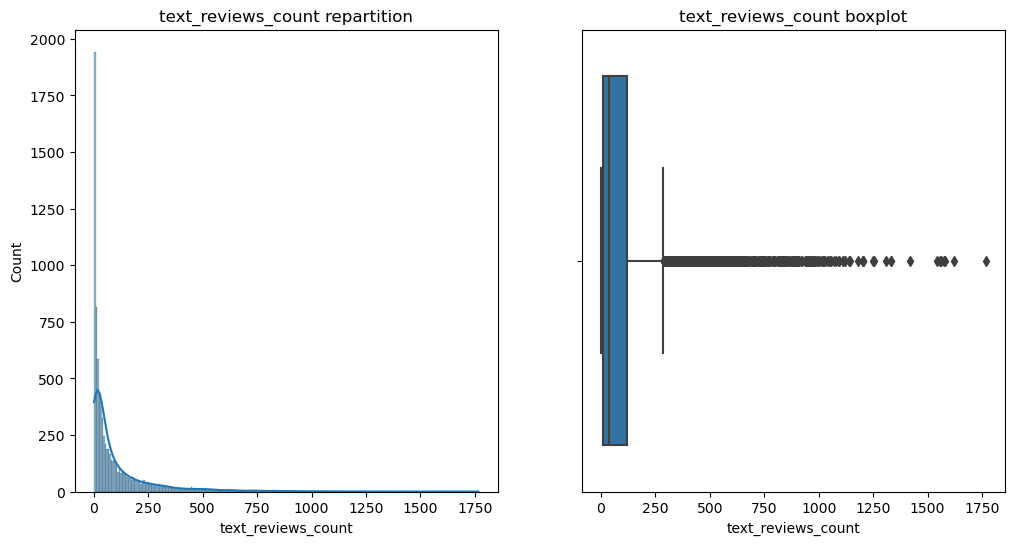

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs.flat[0].set_title('text_reviews_count repartition')
sns.histplot(data=df, x='text_reviews_count', bins=250, kde=True, ax=axs[0])
axs.flat[1].set_title('text_reviews_count boxplot')
sns.boxplot(data=df, x='text_reviews_count', ax=axs[1])

plt.show()

In [34]:
q1, q3 = df['text_reviews_count'].quantile(0.25), df['text_reviews_count'].quantile(0.75)
trc_iqr = q3 - q1
trc_low, trc_up = q1 - (1.5 * trc_iqr), q3 + (1.5 * trc_iqr)
print(f"Lower outliers : {trc_low}\nUpper outliers : {trc_up}")

Lower outliers : -157.5
Upper outliers : 286.5


In [35]:
print(f"text_reviews_count total outliers : {df.loc[df['text_reviews_count'] > trc_up].shape[0]}")

text_reviews_count total outliers : 853


In [36]:
df = df.loc[df['text_reviews_count'] <= trc_up]
df = df.loc[df['text_reviews_count'] > 0]
print(f"Dataset rows : {df.shape[0]}")

Dataset rows : 7429


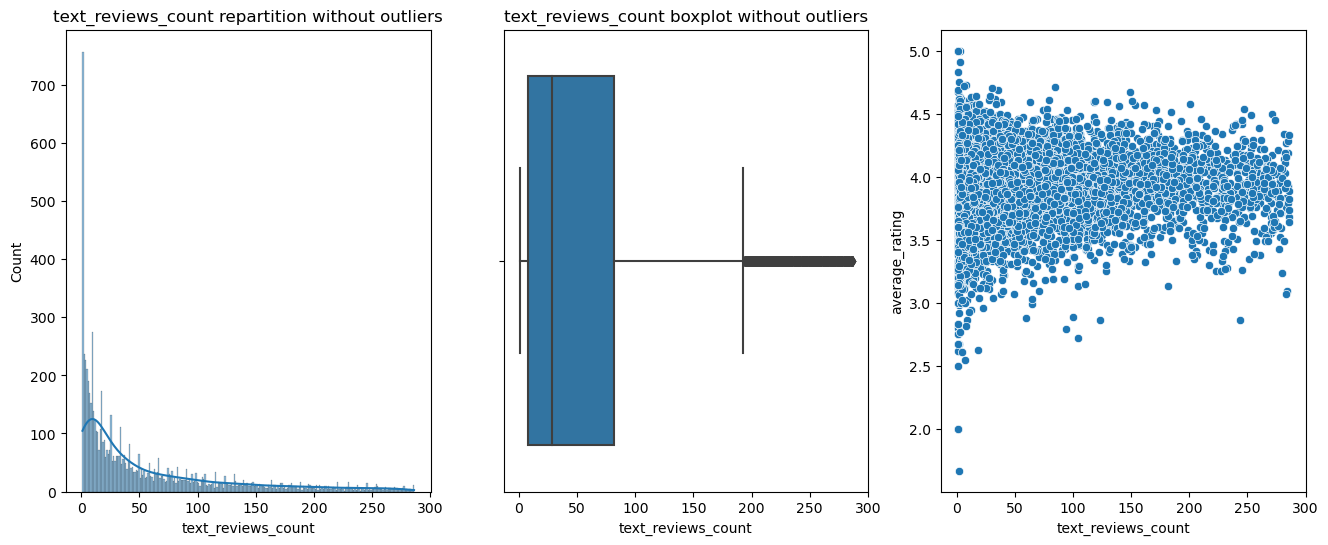

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs.flat[0].set_title('text_reviews_count repartition without outliers')
sns.histplot(data=df, x='text_reviews_count', bins=250, kde=True, ax=axs[0])
axs.flat[1].set_title('text_reviews_count boxplot without outliers')
sns.boxplot(data=df, x='text_reviews_count', ax=axs[1])
sns.scatterplot(data=df, x='text_reviews_count', y='average_rating', ax=axs[2])

plt.show()

<a id="2.4"></a>
## [2.4 Rating by reviews](#2.4)
[Sommaire](#0)

In [38]:
df['rating_by_reviews'] = df['ratings_count'] / df['text_reviews_count']

In [39]:
df['rating_by_reviews'].describe()

count    7429.000000
mean       20.476122
std        23.779044
min         1.000000
25%         8.500000
50%        13.500000
75%        23.292683
max       466.500000
Name: rating_by_reviews, dtype: float64

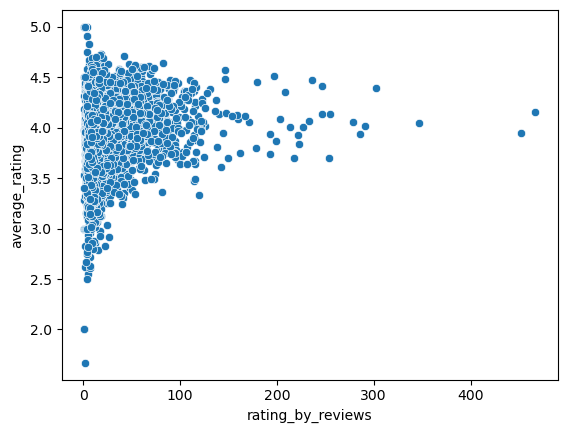

Pearson : 0.1583318626810499
Spearman : 0.1713810202965842


In [40]:
sns.scatterplot(data=df, x='rating_by_reviews', y='average_rating')
plt.show()
print(f"Pearson : {np.corrcoef(df['rating_by_reviews'], df['average_rating'])[0, 1]}")
print(f"Spearman : {stats.spearmanr(df['rating_by_reviews'], df['average_rating'])[0]}")

<a id="2.5"></a>
## [2.5 Reviews by ratings](#2.5)
[Sommaire](#0)

In [41]:
df['reviews_by_ratings'] = df['text_reviews_count'] / df['ratings_count']

In [42]:
df['reviews_by_ratings'].describe()

count    7429.000000
mean        0.091182
std         0.078375
min         0.002144
25%         0.042932
50%         0.074074
75%         0.117647
max         1.000000
Name: reviews_by_ratings, dtype: float64

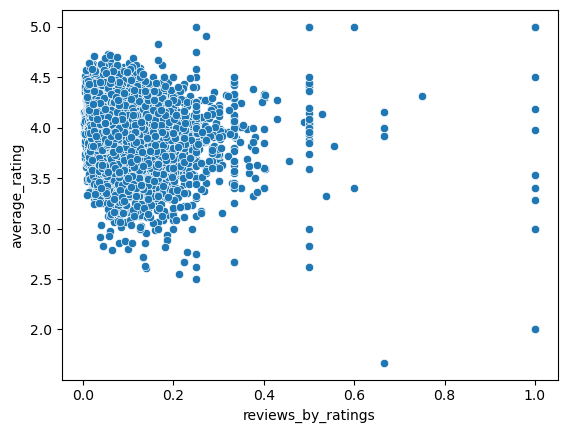

Pearson : -0.14745551851911246
Spearman : -0.1713810202965842


In [43]:
sns.scatterplot(data=df, x='reviews_by_ratings', y='average_rating')
plt.show()
print(f"Pearson : {np.corrcoef(df['reviews_by_ratings'], df['average_rating'])[0, 1]}")
print(f"Spearman : {stats.spearmanr(df['reviews_by_ratings'], df['average_rating'])[0]}")

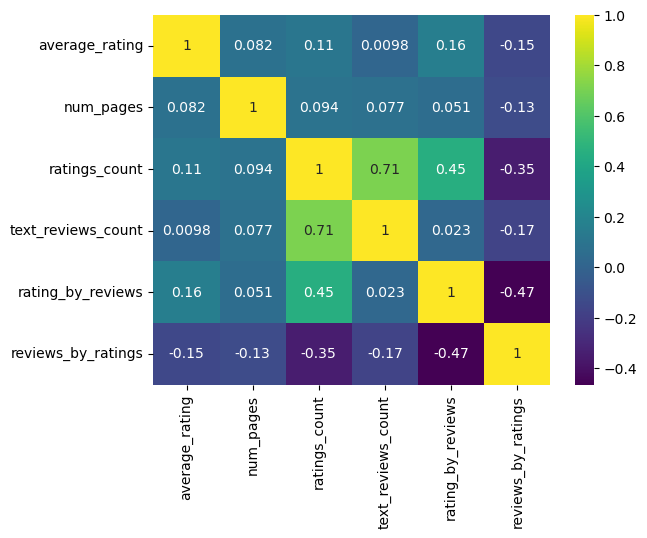

In [44]:
sns.heatmap(df[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'rating_by_reviews', 'reviews_by_ratings']].corr(), annot=True, cmap='viridis')
plt.show()

<a id="2.6"></a>
## [2.6 Publishers](#2.6)
[Sommaire](#0)

In order to see the number of books published by a unique publisher we create a new dataframe which contains the total number of published book, and also the average rating given by publisher

In [45]:
df_publi = df.groupby('publisher').agg({'title': 'count', 'average_rating': 'mean'}).sort_values(by='average_rating' ,ascending=False)
df_publi = df_publi.reset_index()
df_publi.sort_values(by='title')

,publisher,title,average_rating
0,University Press of New England,1,5.000000
1095,Byblos,1,3.890000
1094,Collectors Library,1,3.890000
1092,Nova Fronteira,1,3.890000
1091,FASA Corp.,1,3.890000
...,...,...,...
1309,Ballantine Books,77,3.817273
868,Mariner Books,105,3.957905
947,Penguin Classics,118,3.932712
1050,Penguin Books,159,3.905031


<Axes: xlabel='title', ylabel='Count'>

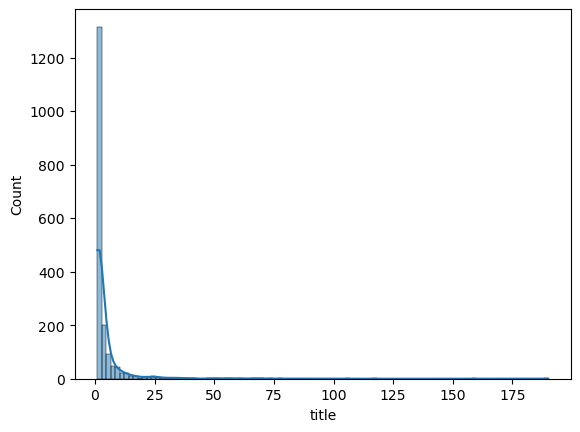

In [46]:
sns.histplot(data=df_publi, x='title', bins=100, kde=True)

In [47]:
df_publi['title'].describe()

count    1839.000000
mean        4.039695
std        10.004028
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       190.000000
Name: title, dtype: float64

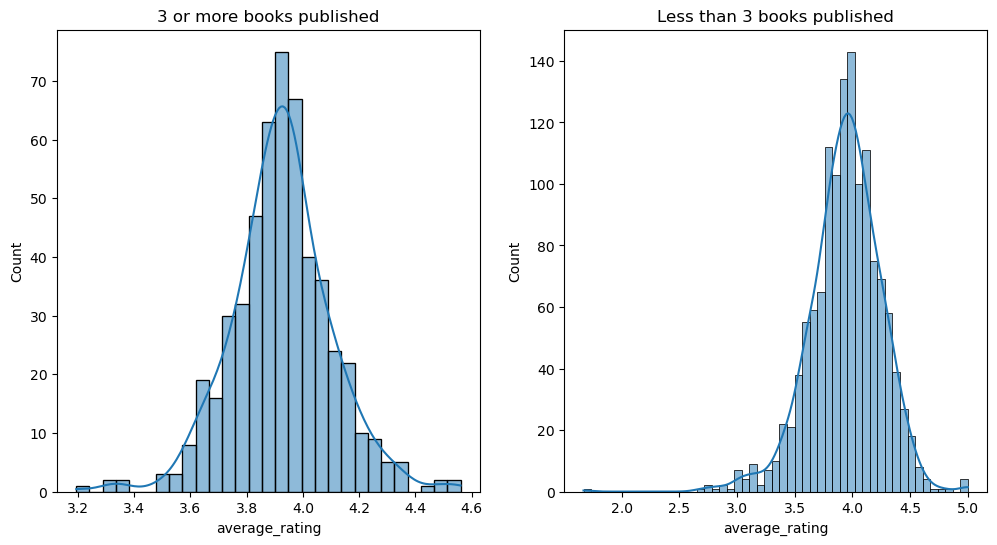

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs.flat[0].set_title('3 or more books published')
sns.histplot(df_publi.loc[df_publi['title'] >= 3, 'average_rating'], kde=True, ax=axs[0])
axs.flat[1].set_title('Less than 3 books published')
sns.histplot(df_publi.loc[df_publi['title'] < 3, 'average_rating'], kde=True, ax=axs[1])
plt.show()

The following graph shows a comparison between the choosen splitter for the publisher vs a normal distribution (red line)
* Below 3.5 it gets messy
* Above 4.4 also

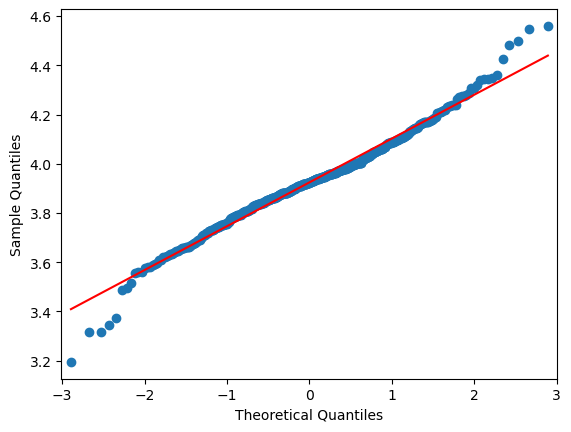

In [49]:
sm.qqplot(df_publi.loc[df_publi['title'] >= 3, 'average_rating'], line='s')
plt.show()

- The 3rd percentile is 75% and is at 3 books published, but when looking deeper
- 1933 publishers have published less than 3 books

In [50]:
print('Publishers that have published less than 3 books')
print(df_publi.loc[df_publi['title'] < 3, 'title'].cumsum())
print('-'*100)
print('Publisher that have publisher 3 or more books')
print(df_publi.loc[df_publi['title'] >= 3, 'title'].cumsum())

Publishers that have published less than 3 books
0          1
1          2
2          3
3          4
4          5
        ... 
1834    1589
1835    1590
1836    1592
1837    1593
1838    1594
Name: title, Length: 1315, dtype: int64
----------------------------------------------------------------------------------------------------
Publisher that have publisher 3 or more books
18         3
20         8
28        11
38        24
64        27
        ... 
1785    5821
1791    5824
1796    5828
1797    5831
1809    5835
Name: title, Length: 524, dtype: int64


In [51]:
""" Create the group of publisher that have published less than 3 books
    And setting to this group a factor value of 0
    Then the other on will have a factor value whose correspond to the
    ith new encoutered element """
i = 1
for n in range(df_publi.shape[0]):
    if df_publi['publisher'].iloc[n] in df_publi.loc[df_publi['title'] < 3, 'publisher'].values.tolist():
        df_publi.loc[n, 'factor'] = 0
    else:
        df_publi.loc[n, 'factor'] = i
        i += 1

In [52]:
""" Mapping the factor value created above to the whole dataset """
df = df.reset_index().drop(columns=['index'])
for n in range(df.shape[0]):
    df.loc[n, 'factor'] = df_publi.loc[df_publi['publisher'] == df.loc[n, 'publisher'], 'factor'].values[0]

In [53]:
print(f"Unique factor created : {df_publi['factor'].nunique()}")
print(f"Unique factor in the whole dataset : {df['factor'].nunique()}")

Unique factor created : 525
Unique factor in the whole dataset : 525


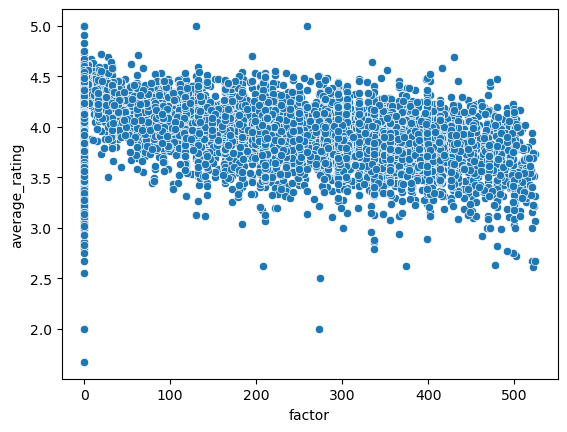

Pearson : -0.2973684793680984
Spearman : -0.2920197078391802


In [54]:
sns.scatterplot(data=df, x='factor', y='average_rating')
plt.show()
print(f"Pearson : {np.corrcoef(df['factor'], df['average_rating'])[0, 1]}")
print(f"Spearman : {stats.spearmanr(df['factor'], df['average_rating'])[0]}")

<Axes: xlabel='average_rating', ylabel='Count'>

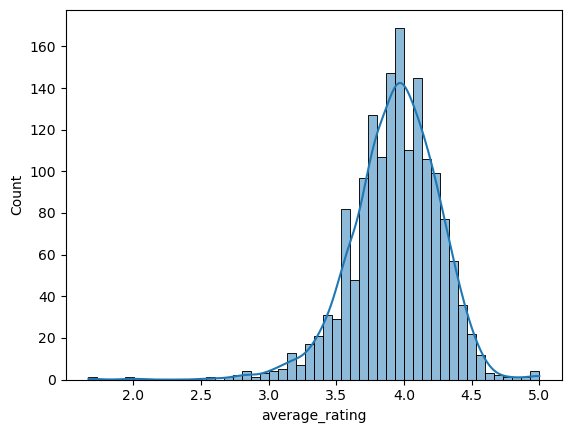

In [55]:
sns.histplot(data=df.loc[df['factor'] == 0], x='average_rating', kde=True)

<a id="2.7"></a>
## [2.7 publication_date](#2.7)
[Sommaire](#0)

In [56]:
df['year'] = df['publication_date'].dt.year
df['year'].describe()

count    7429.000000
mean     1999.702113
std         8.702278
min      1900.000000
25%      1997.000000
50%      2002.000000
75%      2005.000000
max      2019.000000
Name: year, dtype: float64

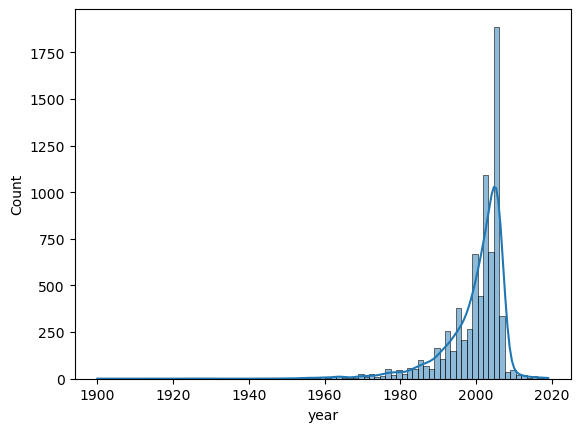

In [57]:
nb_years = len(df['year'].unique())

sns.histplot(df['year'], bins=nb_years, kde=True)
plt.show()

Decile of the number of books published in one year

In [58]:
for i in range(0, 10):
    print(f"{i*10}-{(i+1)*10}% : {df.groupby('year')['average_rating'].count().quantile((i+1)/10)}")

0-10% : 1.0
10-20% : 2.0
20-30% : 4.0
30-40% : 5.0
40-50% : 11.0
50-60% : 22.0
60-70% : 30.999999999999993
70-80% : 97.20000000000014
80-90% : 290.5999999999999
90-100% : 1084.0


In [59]:
df_yr = df.groupby('year')['average_rating'].agg(['count', 'min', 'max', 'mean', 'median', 'std'])

ANOVA can be computed because the 3 assumptions are satisfied :
1. Samples are independent
2. Samples from a normally distributed population
3. Population standard deviation of the groupes are equal : Homoscedascity

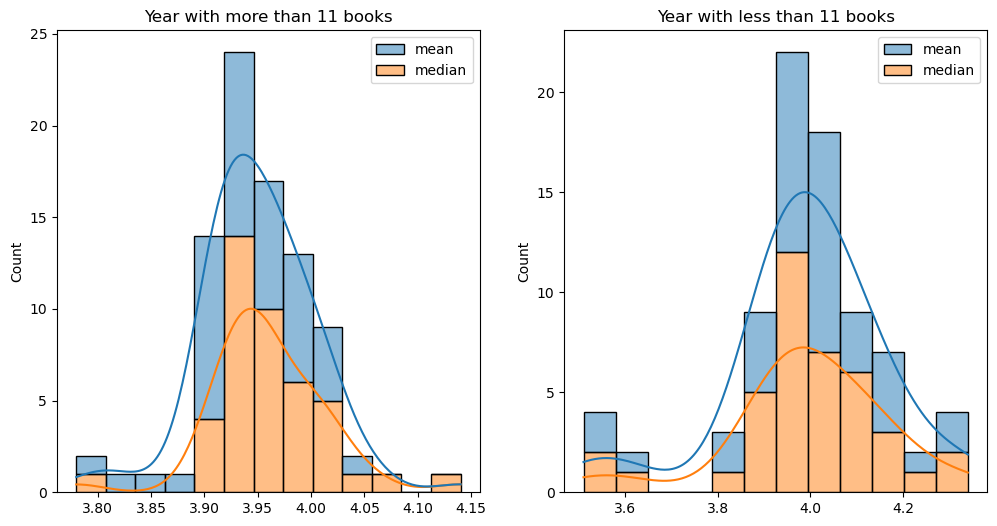

ANOVA p-value : 0.0739240835301232


In [60]:
threshold = 11
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs.flat[0].set_title(f'Year with more than {threshold} books')
sns.histplot(df_yr.loc[df_yr['count'] >= threshold, ['mean', 'median']], kde=True, multiple='stack', ax=axs[0])
axs.flat[1].set_title(f'Year with less than {threshold} books')
sns.histplot(df_yr.loc[df_yr['count'] < threshold, ['mean', 'median']], kde=True, multiple='stack', ax=axs[1])

plt.show()
print(f"ANOVA p-value : {stats.f_oneway(df_yr.loc[df_yr['count'] >= threshold, 'mean'], df_yr.loc[df_yr['count'] < threshold, 'mean'])[1]}")


Dict composed of :
- As keys : A threshold to separate years according to numbers of book published during this year
- As values : ANOVA p-value

We can see that there isn't a threshold for which there is a significant difference in group means

In [61]:
anova_dict = {}
for i in range(2, 22):
    anova_dict[i] = stats.f_oneway(df_yr.loc[df_yr['count'] >= i, 'mean'], df_yr.loc[df_yr['count'] < i, 'mean'])[1]
    
anova_dict

{2: 0.7394299966513276,
 3: 0.7234344698172446,
 4: 0.3815663851555121,
 5: 0.20705669074219135,
 6: 0.07677173914342704,
 7: 0.11839374886396614,
 8: 0.1465152214151905,
 9: 0.08904846964864666,
 10: 0.08604488957627913,
 11: 0.0739240835301232,
 12: 0.13712360159469628,
 13: 0.15956959247741928,
 14: 0.1481592949561583,
 15: 0.24395423044893383,
 16: 0.24395423044893383,
 17: 0.24395423044893383,
 18: 0.24395423044893383,
 19: 0.28746261386333366,
 20: 0.28746261386333366,
 21: 0.28746261386333366}

The idea here is to retrieve years in decile, based on the average rating during the year    

In [62]:
print(df_yr.loc[df_yr['count'] >= 10, 'count'].cumsum().values[-1])
print(df.shape[0])
print(f"Nb of line loss : {df.shape[0] - df_yr.loc[df_yr['count'] >= 10, 'count'].cumsum().values[-1]}")

7306
7429
Nb of line loss : 123


In [63]:
dfy10 = df_yr.loc[df_yr['count'] >= 10]
dfy10.sort_values(by='mean')

,count,min,max,mean,median,std
year,,,,,,
1964,14,3.12,4.37,3.805000,3.780,0.358174
2012,11,2.83,4.43,3.818182,3.930,0.409630
1972,11,3.46,4.20,3.854545,3.900,0.277718
1976,23,3.33,4.22,3.886957,3.920,0.249061
1999,296,2.80,4.64,3.893750,3.905,0.250560
1987,68,3.25,4.43,3.895588,3.925,0.278361
1994,150,2.61,4.54,3.900400,3.915,0.300167
2007,334,2.89,5.00,3.903234,3.920,0.307739
2009,27,3.17,4.40,3.903333,4.040,0.311065


In [64]:
q1 = dfy10['mean'].quantile(0.25)
q2 = dfy10['mean'].quantile(0.5)
q3 = dfy10['mean'].quantile(0.75)
print('Mean quantile')
print(q1)
print(q2)
print(q3)
print('-'*100)
print('Median quantile')
print(dfy10['median'].quantile(0.25))
print(dfy10['median'].quantile(0.5))
print(dfy10['median'].quantile(0.75))

Mean quantile
3.909089725167698
3.9341390282388318
3.9785314685314686
----------------------------------------------------------------------------------------------------
Median quantile
3.93
3.955
3.99625


In [65]:
year_q1 = dfy10.loc[dfy10['mean'] <= q1]
year_q2 = dfy10.loc[(dfy10['mean'] > q1) & (dfy10['mean'] <= q2)]
year_q3 = dfy10.loc[(dfy10['mean'] > q2) & (dfy10['mean'] <= q3)]
year_q4 = dfy10.loc[dfy10['mean'] > q3]

<Axes: ylabel='Count'>

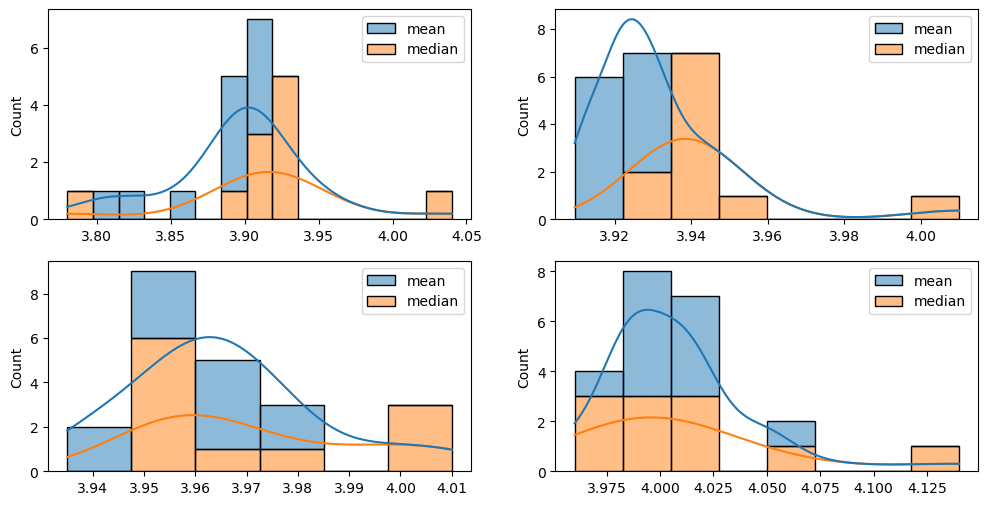

In [66]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

sns.histplot(year_q1[['mean', 'median']], kde=True, multiple='stack', ax=axs[0, 0])
sns.histplot(year_q2[['mean', 'median']], kde=True, multiple='stack', ax=axs[0, 1])
sns.histplot(year_q3[['mean', 'median']], kde=True, multiple='stack', ax=axs[1, 0])
sns.histplot(year_q4[['mean', 'median']], kde=True, multiple='stack', ax=axs[1, 1])

In [67]:
year_q1['count'].cumsum()

year
1964      14
1972      25
1976      48
1987     116
1994     266
1998     535
1999     831
2007    1165
2009    1192
2011    1210
2012    1221
Name: count, dtype: int64

In [68]:
stats.f_oneway(year_q1['mean'], year_q2['mean'], year_q3['mean'], year_q4['mean'])

F_onewayResult(statistic=61.88895370781866, pvalue=4.3920629257880706e-15)

In [69]:
df['year_q1'] = 0
for years in year_q1.index:
    df['year_q1'] = np.where(df['year'] == years, 1, df['year_q1'])

df['year_q2'] = 0
for years in year_q2.index:
    df['year_q2'] = np.where(df['year'] == years, 1, df['year_q2'])

df['year_q3'] = 0
for years in year_q3.index:
    df['year_q3'] = np.where(df['year'] == years, 1, df['year_q3'])

df['year_q4'] = 0
for years in year_q4.index:
    df['year_q4'] = np.where(df['year'] == years, 1, df['year_q4'])

<Axes: >

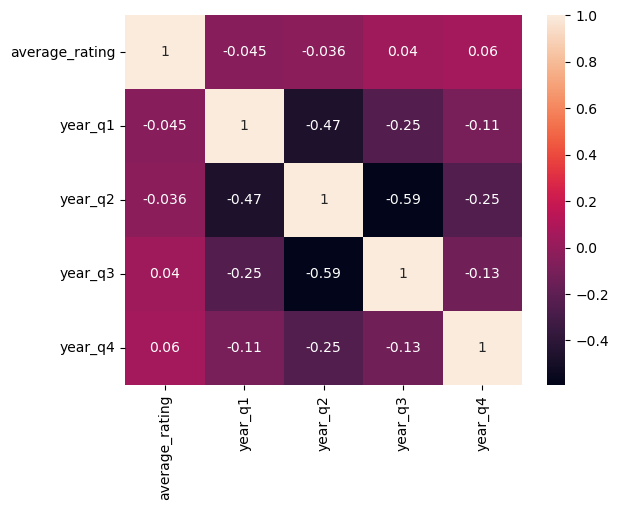

In [70]:
sns.heatmap(df[['average_rating', 'year_q1', 'year_q2', 'year_q3', 'year_q4']].corr(), annot=True)

In [71]:
rating_quantile = []
for i in range(0, 10):
    if i == 9:
        print(f"90-99% : < {df['average_rating'].quantile(0.99)}")
        print(f"99-100% : < {df['average_rating'].quantile(1)}")
        break
    print(f"{i*10}-{(i+1)*10}% : < {df['average_rating'].quantile((i+1)/10)}")
    rating_quantile.append(df['average_rating'].quantile((i+1)/10))

0-10% : < 3.56
10-20% : < 3.71
20-30% : < 3.8
30-40% : < 3.88
40-50% : < 3.94
50-60% : < 4.01
60-70% : < 4.08
70-80% : < 4.16
80-90% : < 4.27
90-99% : < 4.53
99-100% : < 5.0


<a id="2.8"></a>
## [2.8 Adapting *authors*](#2.8)
[Sommaire](#0)

First problem, the ***authors*** columns contains 6582 unique values

In [72]:
df['authors'].describe()

count                 7429
unique                5091
top       Rumiko Takahashi
freq                    30
Name: authors, dtype: object

Below, we can see that if there is that much unique values, it's because authors columns contains string values, and one string can contain multiple authors that are separated by **/**

In [73]:
all_authors = df['authors'].tolist()
print(all_authors[:5])
print(len(all_authors))

['J.K. Rowling', 'W. Frederick Zimmerman', 'Douglas Adams/Stephen Fry', 'Bill Bryson', 'Jude Fisher']
7429


We create an author dict that will contains as key the author name, and as value the number of occurence of this author in the whole dataset

In [74]:
author_dict = {}
for authors in all_authors:
    authors_list = authors.split('/')
    for author in authors_list:
        if author not in author_dict:
            author_dict[author] = 1
        else:
            author_dict[author] += 1

In [75]:
d = {"Author_name": list(author_dict.keys()), "count": list(author_dict.values())}

In [76]:
author_df = pd.DataFrame(data=d)

In [77]:
aut_tresh = 15
author_df.loc[author_df['count'] >= aut_tresh].sort_values(by='count', ascending=False)

,Author_name,count
308,William Shakespeare,74
1055,Stephen King,60
5170,Sandra Brown,39
2989,P.G. Wodehouse,36
517,J.R.R. Tolkien,36
2617,Mercedes Lackey,33
3997,Rumiko Takahashi,30
2856,Piers Anthony,28
1623,Dick Francis,28
1054,Margaret Weis,27


In [78]:
top_authors = author_df.loc[author_df['count'] >= aut_tresh, 'Author_name'].unique()

In [79]:
top_aut_anova = {}

In [80]:
for aut in top_authors:
    df[aut] = 0
    df[aut] = np.where(df['authors'].str.contains(aut), 1, df[aut])

    anov = stats.f_oneway(df.loc[df[aut] == 0, 'average_rating'], df.loc[df[aut] == 1, 'average_rating'])[1]
    if aut not in top_aut_anova:
        top_aut_anova[aut] = anov


In [81]:
aut_analys_df = pd.DataFrame()

In [82]:
aut_analys_df['authors'] = top_aut_anova.keys()

In [83]:
aut_analys_df['p_value'] = top_aut_anova.values()

In [84]:
np.corrcoef(df["Rumiko Takahashi"], df['average_rating'])[0, 1]

0.05726748372327082

In [85]:
for aut in aut_analys_df['authors']:
    aut_analys_df.loc[aut_analys_df['authors'] == aut, 'pearson'] = np.corrcoef(df[aut], df['average_rating'])[0, 1]

In [86]:
aut_analys_df.loc[aut_analys_df['p_value'] < 0.05].sort_values(by='pearson')

,authors,p_value,pearson
48,Sandra Brown,1.016811e-08,-0.066393
28,Francine Pascal,1.393890e-05,-0.050385
39,Piers Anthony,2.309365e-05,-0.049086
13,Herman Melville,2.991085e-05,-0.048408
25,Orson Scott Card,2.723734e-04,-0.042223
21,Margaret Weis,5.356810e-03,-0.032306
30,Joyce Carol Oates,7.476327e-03,-0.031031
43,Alan Dean Foster,1.530922e-02,-0.028134
22,Stephen King,2.364187e-02,0.026254
9,Jane Austen,1.679371e-02,0.027742


In [87]:
top_authors = aut_analys_df.loc[(aut_analys_df['p_value'] < 0.05) & (aut_analys_df['pearson'] > 0), ['authors', 'pearson']]
bad_authors = aut_analys_df.loc[(aut_analys_df['p_value'] < 0.05) & (aut_analys_df['pearson'] < 0), ['authors', 'pearson']]

In [88]:
df['top_author'] = 0
for aut in top_authors['authors']:
    df['top_author'] = np.where(df['authors'].str.contains(aut), 1, df['top_author'])

df['bad_author'] = 0
for aut in bad_authors['authors']:
    df['bad_author'] = np.where(df['authors'].str.contains(aut), 1, df['bad_author'])

In [89]:
df.loc[df['top_author']==1, 'average_rating'].count()

397

In [90]:
for i in range(len(df)):
    df.loc[i, 'n_authors'] = len(df.loc[i, 'authors'].split('/'))

In [91]:
df.sample(3)

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,rating_by_reviews,...,P.G. Wodehouse,Alan Dean Foster,Grant Morrison,Rumiko Takahashi,Tracy Hickman,Jack Vance,Sandra Brown,top_author,bad_author,n_authors
1340,Betsy and Tacy Go Downtown (Betsy-Tacy #4),Maud Hart Lovelace/Lois Lenski,4.21,eng,180,70,7,1943-01-01,Thomas Y. Crowell Company,10.000000,...,0,0,0,0,0,0,0,0,0,2.0
2942,Alberic the Wise,Norton Juster/Leonard Baskin,3.73,eng,24,103,9,1992-09-01,Picture Book Studio Ltd,11.444444,...,0,0,0,0,0,0,0,0,0,2.0
4816,Combray (Remembrance of Things Past #1),Stéphane Heuet/Marcel Proust/Joe Johnson,3.79,eng,72,36,9,2001-01-01,Nantier Beall Minoustchine Publishing,4.000000,...,0,0,0,0,0,0,0,0,0,3.0


In [92]:
df.groupby('n_authors')['average_rating'].agg(['count', 'max', 'min', 'mean', 'median', 'std'])

,count,max,min,mean,median,std
n_authors,,,,,,
1.0,4114,5.00,1.67,3.900775,3.920,0.291556
2.0,2218,5.00,2.00,3.953882,3.970,0.276641
3.0,743,5.00,2.00,3.982261,4.000,0.282491
4.0,155,4.58,3.31,4.025161,4.040,0.250769
5.0,47,4.39,3.38,3.966383,4.000,0.258318
6.0,44,4.62,3.21,3.970455,3.940,0.358654
7.0,17,4.59,3.69,4.097647,4.080,0.273873
8.0,9,4.23,3.16,3.622222,3.590,0.349062
9.0,7,4.21,3.12,3.735714,3.760,0.333709


<a id='2.8.1'></a>
### [2.8.1 Groupping authors](#2.8.1)
[Sommaire](#0)

One hot encoding on 
- 1 author
- 2 author
- 3 author
- minus 6 author
- rest

Create a feature that represents the belonging to a class seen before (1, 2, 3, minus 6, other) and then perform a one hot encoding on. Transform to a categorical variable then into a numerical

In [93]:
df['n_authors_group'] = 'TBD'
df['n_authors_group'] = np.where(df['n_authors'] == 1, 'G1', df['n_authors_group'])
df['n_authors_group'] = np.where(df['n_authors'] == 2, 'G2', df['n_authors_group'])
df['n_authors_group'] = np.where(df['n_authors'] == 3, 'G3', df['n_authors_group'])
df['n_authors_group'] = np.where((df['n_authors'] > 3) & (df['n_authors'] <= 6), 'G4', df['n_authors_group'])
df['n_authors_group'] = np.where(df['n_authors_group'] == 'TBD', 'G5', df['n_authors_group'])

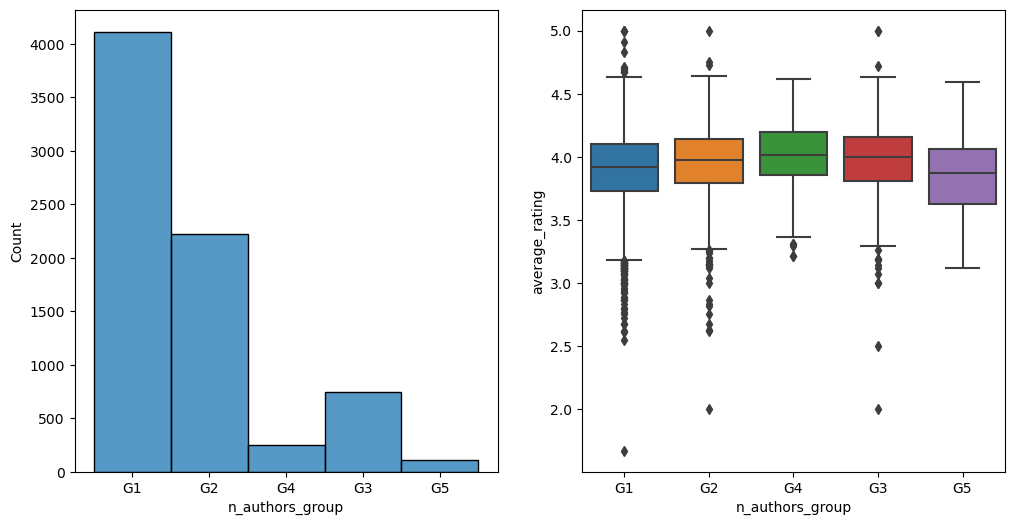

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs.flat[0]
sns.histplot(data=df, x='n_authors_group', ax=axs[0])
axs.flat[1]
sns.boxplot(data=df, x='n_authors_group', y='average_rating',ax=axs[1])
plt.show()

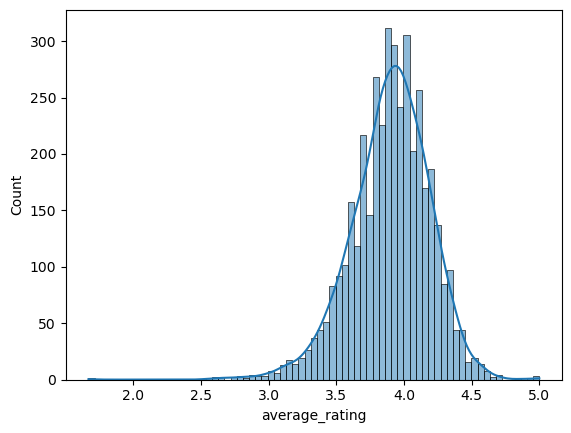

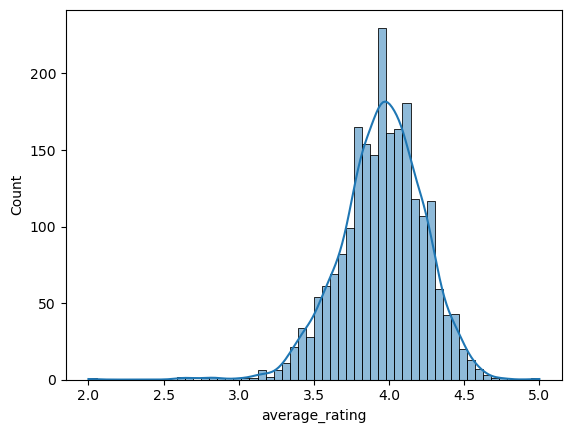

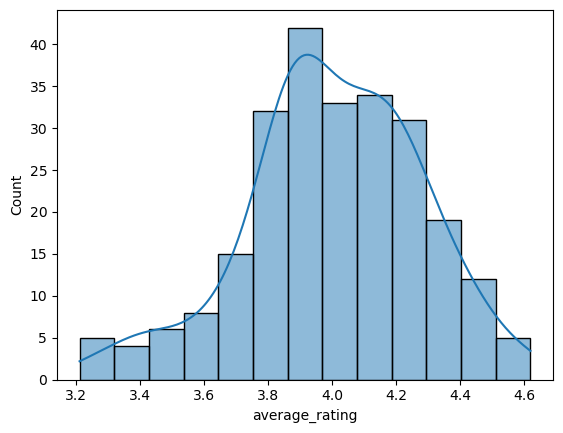

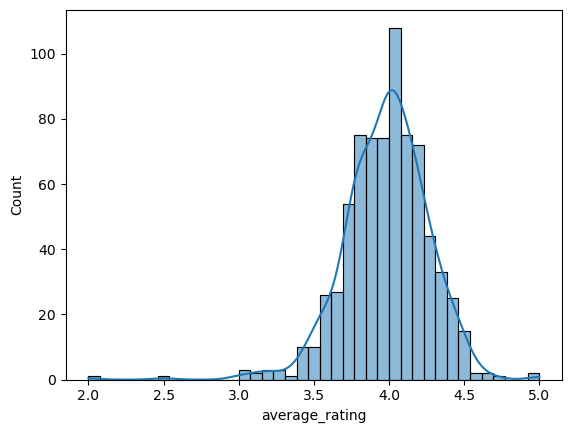

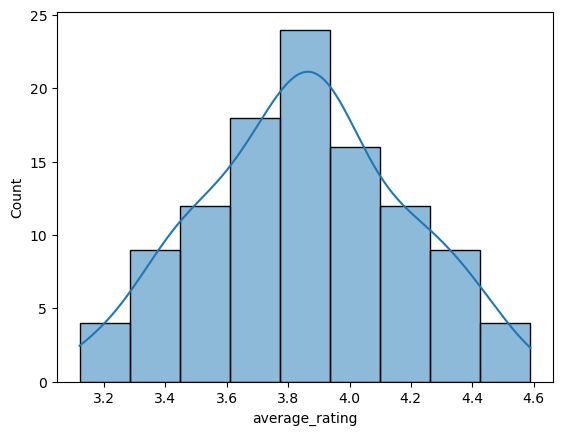

In [95]:
for group in df['n_authors_group'].unique():
    sns.histplot(x=df.loc[df['n_authors_group'] == group, 'average_rating'], kde=True)
    plt.show()

Computing an ANOVA to see if there is a statistical difference in the mean of these 5 groups

In [96]:
anova_f, anova_p = stats.f_oneway(df.loc[df['n_authors_group'] == 'G1', 'average_rating'],
                                   df.loc[df['n_authors_group'] == 'G2', 'average_rating'],
                                   df.loc[df['n_authors_group'] == 'G3', 'average_rating'],
                                   df.loc[df['n_authors_group'] == 'G4', 'average_rating'],
                                   df.loc[df['n_authors_group'] == 'G5', 'average_rating'])
print(f"F-statistic : {anova_f}\np-value : {anova_p}")

F-statistic : 26.80051362138189
p-value : 4.158428577455977e-22


In [97]:
for group in df['n_authors_group'].unique():
    df[f'n_authors_{group}'] = 0
    df[f'n_authors_{group}'] = np.where(df['n_authors_group'] == group, 1, df[f'n_authors_{group}'])

<Axes: >

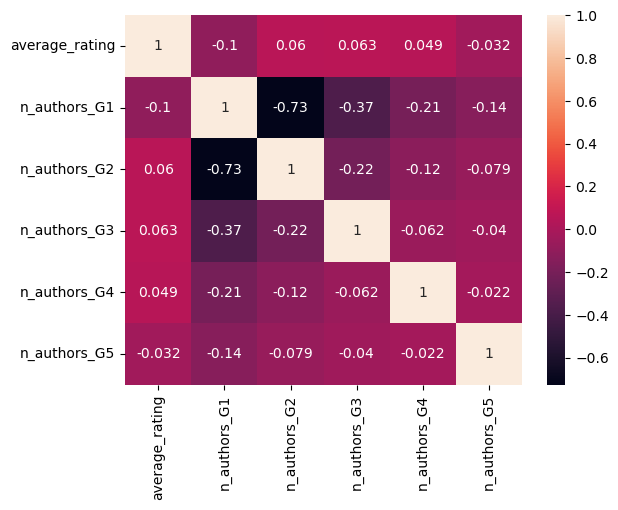

In [98]:
sns.heatmap(df[['average_rating', 'n_authors_G1', 'n_authors_G2', 'n_authors_G3', 'n_authors_G4', 'n_authors_G5']].corr(), annot=True)

In [99]:
df.columns.tolist()

['title',
 'authors',
 'average_rating',
 'language_code',
 'num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher',
 'rating_by_reviews',
 'reviews_by_ratings',
 'factor',
 'year',
 'year_q1',
 'year_q2',
 'year_q3',
 'year_q4',
 'Gabriel García Márquez',
 'Hiromu Arakawa',
 'Plato',
 'Homer',
 'Richmond Lattimore',
 'William Shakespeare',
 'Euripides',
 'Sophocles',
 'Aristophanes',
 'Jane Austen',
 'Charles Dickens',
 'J.R.R. Tolkien',
 'Christopher Tolkien',
 'Herman Melville',
 'Mark Twain',
 'Gordon Korman',
 'Christopher Hitchens',
 'Ray Bradbury',
 'Fyodor Dostoyevsky',
 'Dave Eggers',
 'Kurt Vonnegut Jr.',
 'Margaret Weis',
 'Stephen King',
 'Roald Dahl',
 'James Patterson',
 'Orson Scott Card',
 'Laura Ingalls Wilder',
 'Dick Francis',
 'Francine Pascal',
 'C.S. Lewis',
 'Joyce Carol Oates',
 'Albert Camus',
 'Noam Chomsky',
 'Tom Clancy',
 'Hirohiko Araki',
 'CLAMP',
 'Yumi Hotta',
 'Mercedes Lackey',
 'Virginia Woolf',
 'Piers Anthony',
 'Dan

In [100]:
features_corr = ['num_pages', 'ratings_count', 'text_reviews_count','rating_by_reviews', 'reviews_by_ratings', 'factor',
                'year', 'top_author', 'bad_author', 'n_authors', 'n_authors_G1', 'n_authors_G2', 'n_authors_G3', 
                'n_authors_G4', 'n_authors_G5', 'year_q1', 'year_q2', 'year_q3', 'year_q4']
dependent = ['average_rating']

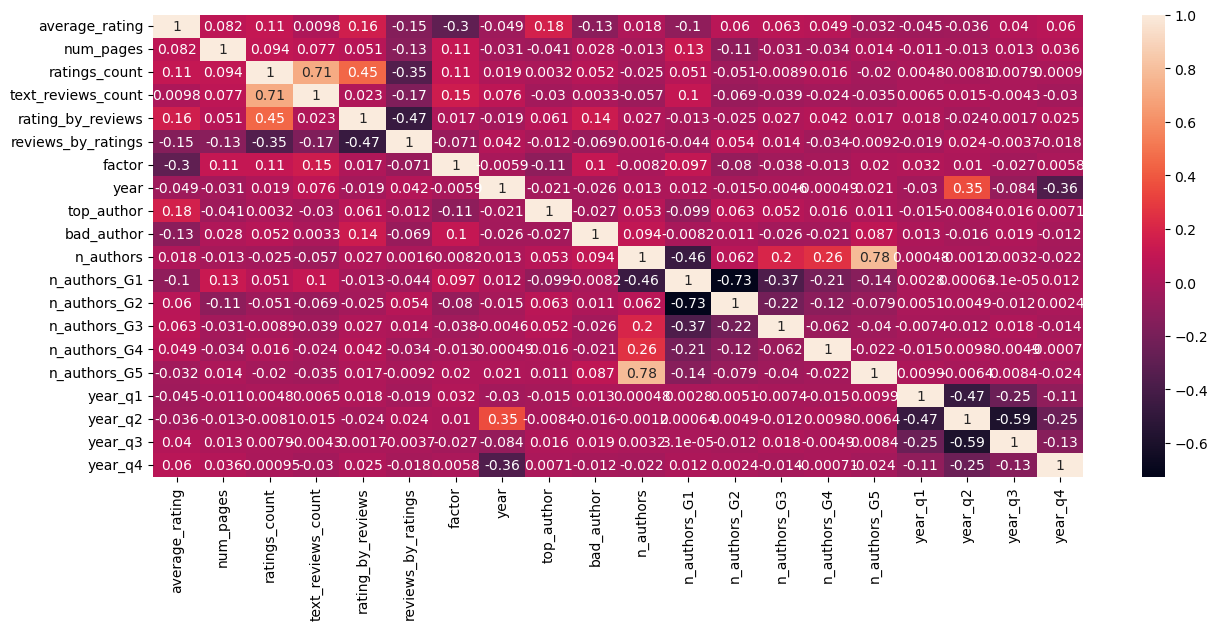

In [101]:
plt.figure(figsize=(15, 6))
sns.heatmap(df[dependent+features_corr].corr(), annot=True)
plt.show()

<a id='2.9'></a>
### [2.9 Features scaling](#2.9)
[Sommaire](#0)

In [102]:
df_test = df[features_corr+dependent].copy()

<Axes: xlabel='factor', ylabel='Count'>

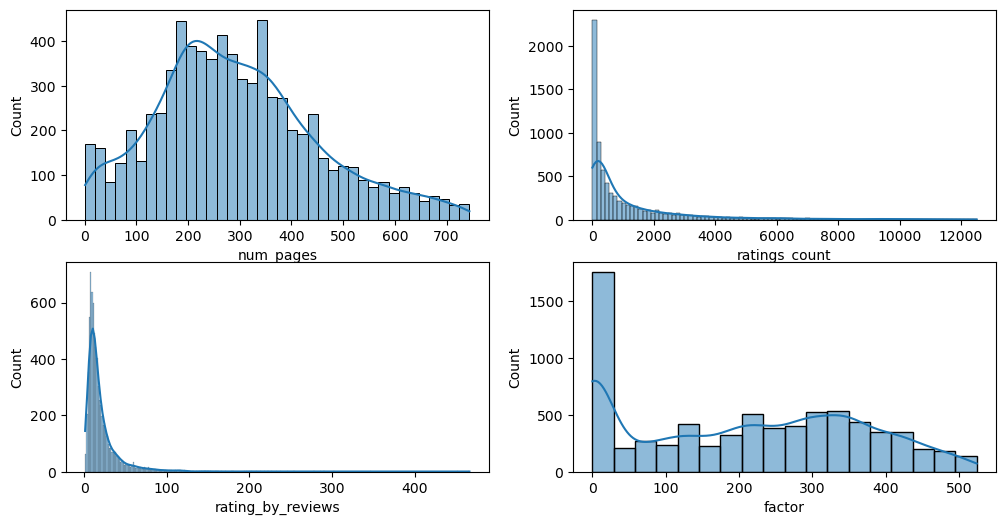

In [103]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

sns.histplot(df_test['num_pages'], kde=True, ax=axs[0, 0])
sns.histplot(df_test['ratings_count'], kde=True, ax=axs[0, 1])
sns.histplot(df_test['rating_by_reviews'], kde=True, ax=axs[1, 0])
sns.histplot(df_test['factor'], kde=True, ax=axs[1, 1])

In [104]:
std_scaler = StandardScaler()

In [105]:
df_test['std_num_pages'] = std_scaler.fit_transform(df_test[['num_pages']])

In [106]:
df_test['log_ratings_count'] = np.log(df_test['ratings_count'])

In [107]:
df_test['log_rating_by_reviews'] = np.log(df_test['rating_by_reviews'])

In [108]:
df_test['std_factor'] = std_scaler.fit_transform(df_test[['factor']])

<Axes: xlabel='std_factor', ylabel='Count'>

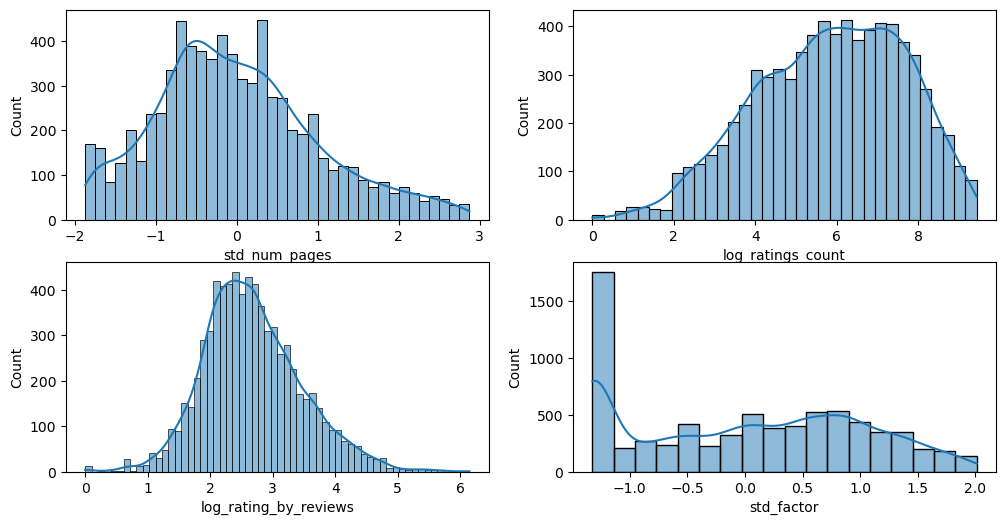

In [109]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

sns.histplot(df_test['std_num_pages'], kde=True, ax=axs[0, 0])
sns.histplot(df_test['log_ratings_count'], kde=True, ax=axs[0, 1])
sns.histplot(df_test['log_rating_by_reviews'], kde=True, ax=axs[1, 0])
sns.histplot(df_test['std_factor'], kde=True, ax=axs[1, 1])

<a id='3'></a>
## [3. Training models](#3)
[Sommaire](#0)

In [110]:
df = df_test.copy()
features = ['std_num_pages', 'log_ratings_count','log_rating_by_reviews','std_factor', 'top_author', 'bad_author', 
                'n_authors_G1', 'n_authors_G2', 'n_authors_G3', 'n_authors_G4', 'n_authors_G5', 
                'year_q1', 'year_q2', 'year_q3', 'year_q4']

<a id='3.1'></a>
### [3.1 Linear Regression](#3.1)
[Sommaire](#0)

In [111]:
random_state = 42
test_size = 0.25
X = df[features]
Y = df['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

linreg = LinearRegression()

linreg.fit(X_train, y_train)
linreg_pred = linreg.predict(X_test)

linreg_score = round(linreg.score(X_test, y_test), 4)
print(linreg_score)

0.1845


In [112]:
for feat, coeff in zip(linreg.feature_names_in_, linreg.coef_):
    print(f"{feat} : {coeff}")

std_num_pages : 0.032755831842654286
log_ratings_count : 0.010528687850364758
log_rating_by_reviews : 0.062264288510562246
std_factor : -0.08306422798563541
top_author : 0.15046499990769419
bad_author : -0.23263747929891665
n_authors_G1 : -0.029966115197194065
n_authors_G2 : 0.0178403928216935
n_authors_G3 : 0.036334618849869695
n_authors_G4 : 0.04124246150104715
n_authors_G5 : -0.06545135797541622
year_q1 : -0.07015418249305232
year_q2 : -0.05151717925597236
year_q3 : -0.028451749725093282
year_q4 : 0.010349315785807268


<a id='3.2'></a>
### [3.2 Decision Tree](#3.2)
[Sommaire](#0)

In [113]:
tree = DecisionTreeRegressor(max_depth=5, random_state=random_state)

tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

tree_score = round(tree.score(X_test, y_test), 4)
print(f"Linear Regression score : {linreg_score}\nDecision Tree score : {tree_score}")

Linear Regression score : 0.1845
Decision Tree score : 0.1368


<a id='3.3'></a>
### [3.3 Random Forest](#3.3)
[Sommaire](#0)

In [114]:
forest = RandomForestRegressor(max_depth=5, oob_score=True, random_state=random_state)

forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)

forest_score = round(forest.score(X_test, y_test), 4)
print(f"Linear Regression score : {linreg_score}\nDecision Tree score : {tree_score}")
print(f"Random Forest score : {forest_score}")

Linear Regression score : 0.1845
Decision Tree score : 0.1368
Random Forest score : 0.19


<a id='3.4'></a>
### [3.4 Gradient Boosting](#3.4)
[Sommaire](#0)

The following parameters were obtained after running a grid search cross validation

In [115]:
g_boost = GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, max_depth=4, verbose=True, random_state=random_state)
g_boost.fit(X_train, y_train)
g_boost_pred = g_boost.predict(X_test)

g_boost_score = round(g_boost.score(X_test, y_test), 4)
print(f"Linear Regression score : {linreg_score}\nDecision Tree score : {tree_score}")
print(f"Random Forest score : {forest_score}\nGradient Boosting score : {g_boost_score}")

      Iter       Train Loss   Remaining Time 
         1           0.0838            7.47s
         2           0.0835            6.96s
         3           0.0832            6.79s
         4           0.0829            6.52s
         5           0.0826            6.39s
         6           0.0824            6.22s
         7           0.0821            6.10s
         8           0.0818            5.94s
         9           0.0816            5.81s
        10           0.0813            5.71s
        20           0.0788            5.27s
        30           0.0767            5.13s
        40           0.0748            5.06s
        50           0.0732            4.95s
        60           0.0717            5.07s
        70           0.0704            5.07s
        80           0.0692            5.03s
        90           0.0681            4.87s
       100           0.0672            4.65s
       200           0.0619            3.24s
       300           0.0593            2.08s
       40

<a id='4'></a>
## [4. Models analysis](#4)
[Sommaire](#0)

In [116]:
model_pred_dic = {'Linear Regression': linreg_pred,
                  'Decision Tree': tree_pred,
                  'Random Forest': forest_pred,
                  'Gradient Boosting': g_boost_pred}
for model, preds in model_pred_dic.items():
    print(model)
    regression_metrics(y_test, preds)
    print('-'*30)

Linear Regression
RMSE : 0.2551
MSE : 0.0651
MAE : 0.1977
R2 : 0.1845
RMSLE : 0.0527
------------------------------
Decision Tree
RMSE : 0.2624
MSE : 0.0689
MAE : 0.2002
R2 : 0.1368
RMSLE : 0.0544
------------------------------
Random Forest
RMSE : 0.2542
MSE : 0.0646
MAE : 0.1949
R2 : 0.1900
RMSLE : 0.0526
------------------------------
Gradient Boosting
RMSE : 0.2486
MSE : 0.0618
MAE : 0.1904
R2 : 0.2251
RMSLE : 0.0515
------------------------------


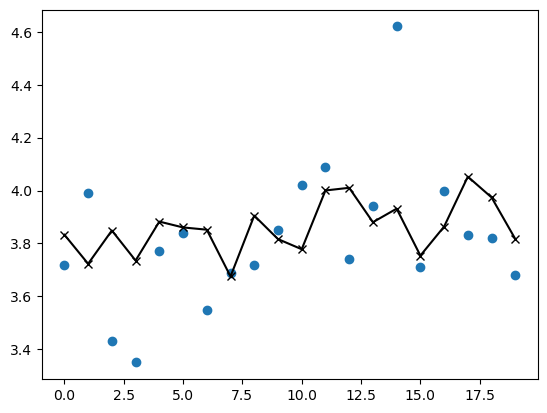

In [117]:
z = 20
plt.plot(y_test.values[:z], 'o', label='Observed')
plt.plot(linreg_pred[:z], 'x-', color='black', label='linreg')

<a id="4.1"></a>
### [4.1 Residuals analysis](#4.1)
[Sommaire](#0)

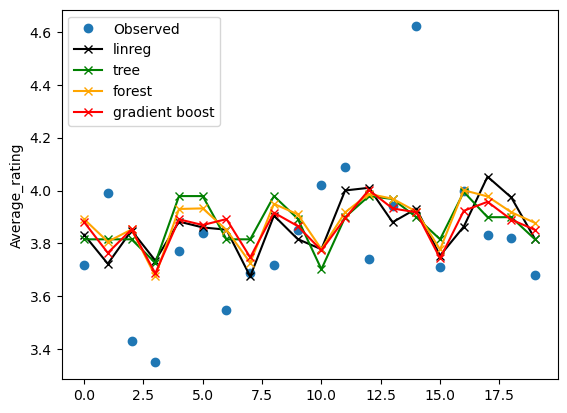

In [118]:
z = 20
plt.plot(y_test.values[:z], 'o', label='Observed')
plt.plot(linreg_pred[:z], 'x-', color='black', label='linreg')
plt.plot(tree_pred[:z], 'x-', color='green', label='tree')
plt.plot(forest_pred[:z], 'x-', color='orange', label='forest')
plt.plot(g_boost_pred[:z], 'x-', color='red', label='gradient boost')
plt.ylabel('Average_rating')
plt.legend()
plt.show()

In [119]:
linreg_residuals = y_test.values - linreg_pred
tree_residuals = y_test.values - tree_pred
forest_residuals = y_test.values - forest_pred
g_boost_residuals = y_test.values - g_boost_pred
residuals_list = [linreg_residuals, tree_residuals, forest_residuals, g_boost_residuals]

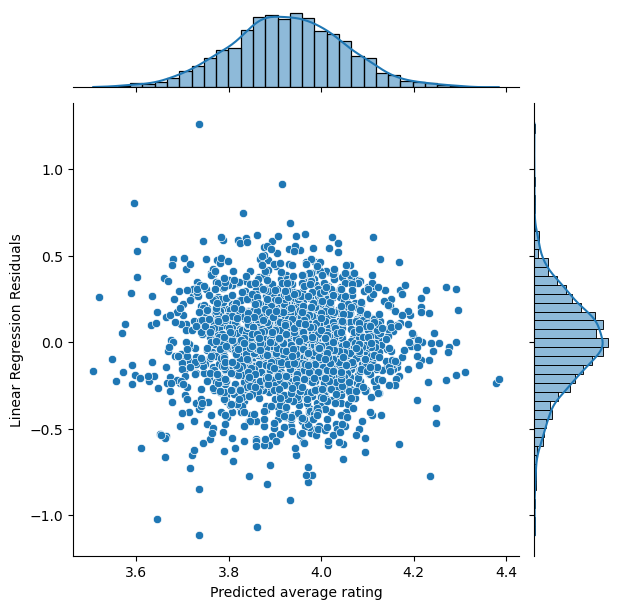

In [132]:
linreg_grid = sns.JointGrid(x=linreg_pred, y=linreg_residuals)
linreg_grid.plot_joint(sns.scatterplot)
linreg_grid.plot_marginals(sns.histplot, kde=True)
linreg_grid.set_axis_labels(xlabel='Predicted average rating', ylabel='Linear Regression Residuals')
plt.show()

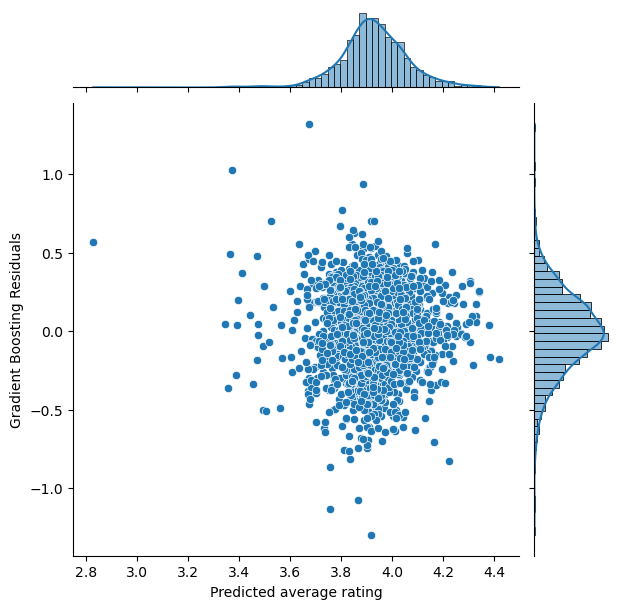

In [131]:
g_boost_grid = sns.JointGrid(x=g_boost_pred, y=g_boost_residuals)
g_boost_grid.plot_joint(sns.scatterplot)
g_boost_grid.plot_marginals(sns.histplot, kde=True)
g_boost_grid.set_axis_labels(xlabel='Predicted average rating', ylabel='Gradient Boosting Residuals')
plt.show()

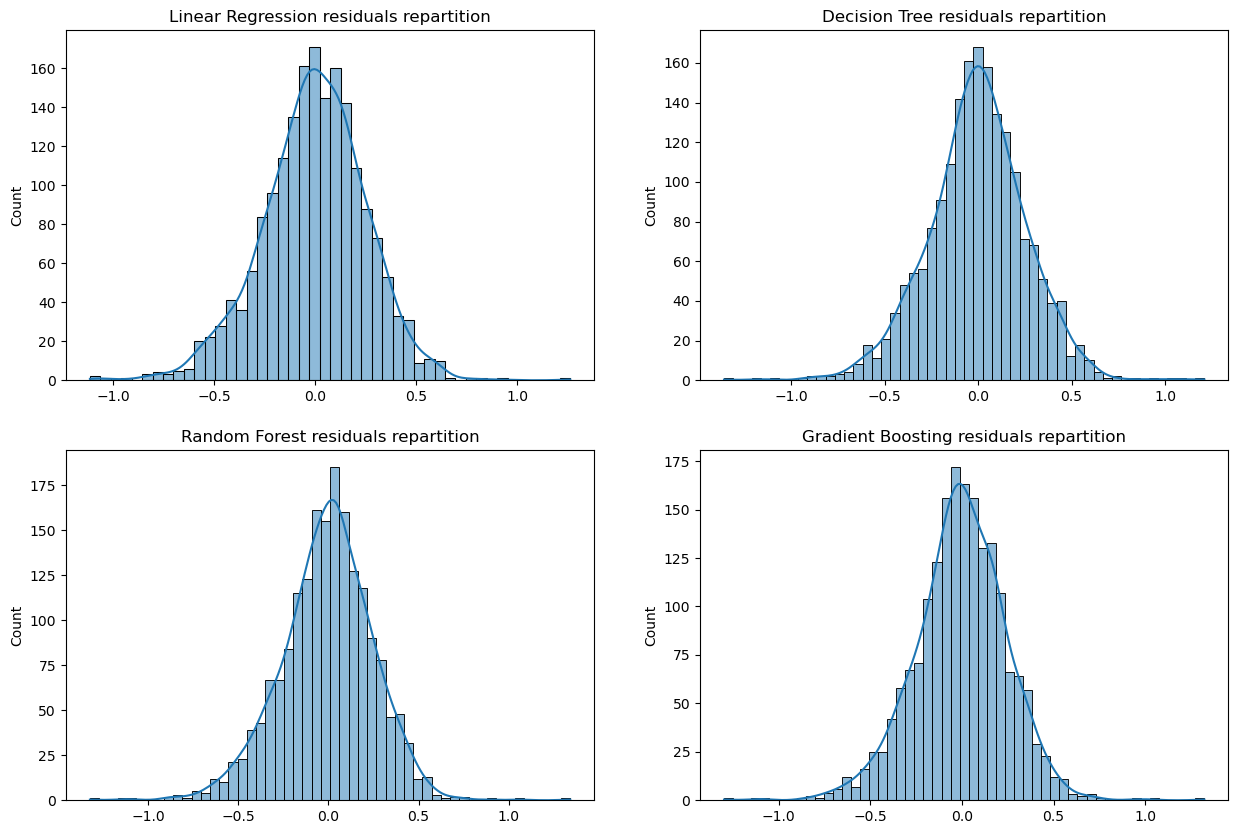

In [122]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].set_title('Linear Regression residuals repartition')
sns.histplot(linreg_residuals, kde=True, ax=axs[0, 0])
axs[0, 1].set_title('Decision Tree residuals repartition')
sns.histplot(tree_residuals, kde=True, ax=axs[0, 1])
axs[1, 0].set_title('Random Forest residuals repartition')
sns.histplot(forest_residuals, kde=True, ax=axs[1, 0])
axs[1, 1].set_title('Gradient Boosting residuals repartition')
sns.histplot(g_boost_residuals, kde=True, ax=axs[1, 1])
plt.show()

In [123]:
for model, residual in zip(model_pred_dic, residuals_list):
    print(model)
    print(f"Residuals mean : {residual.mean():.4f}\nResiduals std : {residual.std():.4f}")
    print('-'*40)

Linear Regression
Residuals mean : -0.0044
Residuals std : 0.2550
----------------------------------------
Decision Tree
Residuals mean : -0.0062
Residuals std : 0.2623
----------------------------------------
Random Forest
Residuals mean : -0.0070
Residuals std : 0.2541
----------------------------------------
Gradient Boosting
Residuals mean : -0.0068
Residuals std : 0.2485
----------------------------------------


In [126]:
for feature, importance in zip(g_boost.feature_names_in_, g_boost.feature_importances_):
    print(f"{feature} : {importance}")
    print('-'*40)

std_num_pages : 0.13316973994726897
----------------------------------------
log_ratings_count : 0.07292895348448851
----------------------------------------
log_rating_by_reviews : 0.18369280165492446
----------------------------------------
std_factor : 0.4842452904955464
----------------------------------------
top_author : 0.03651729416210546
----------------------------------------
bad_author : 0.04296965041227345
----------------------------------------
n_authors_G1 : 0.017283181517701852
----------------------------------------
n_authors_G2 : 0.0011335525936406428
----------------------------------------
n_authors_G3 : 0.004415979868113908
----------------------------------------
n_authors_G4 : 0.0008792612574243903
----------------------------------------
n_authors_G5 : 0.005368199363325936
----------------------------------------
year_q1 : 0.0060344747123290375
----------------------------------------
year_q2 : 0.002268207062815589
----------------------------------------
year